# Import libraries and data

In [110]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib_venn import venn2
from scipy.stats import mannwhitneyu
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [111]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain proteome (HPA)

In [112]:
def get_uniprot(string):
    try:
        _, uniprot, _ = string.split("|")
    except:
        _, uniprot, _ = string.split("_", maxsplit=2)  
    return uniprot

def keep_first_uniprot(string):
    if "," in string:
        uniprots = string.split(",")
        uniprot1 = uniprots[0]
    else:
        uniprot1 = string
    
    return uniprot1

def get_brain_expression(string):
    # check if expression for multiple tissues is provided
    if ";" in string:
        tissues = string.split(";")
        for t in tissues:
            # keep only information on brain expression
            if "brain" in t:
                brain_string = t 
    else:
        brain_string = string
    
    # extract expression value from string
    _, exp = brain_string.split(" ")
    exp = float(exp)

    return exp

def get_brain_expression_detected(string):
    
    # return None is no information is available
    if type(string) != str:
        return None

    # check if expression for multiple tissues is provided
    tissues = string.split(";")
    for t in tissues:
        # keep only information on brain expression
        if "brain" in t:
            brain_string = t 
        else:
            return None
    
    # extract expression value from string
    _, exp = brain_string.split(" ")
    exp = float(exp)

    return exp

In [113]:
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")

In [114]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")

## Feature data sets

In [115]:
# all human proteins
df = pd.read_csv(data_path + "/Features/df_features.csv")
# all proteins detected in brain
df_detected = pd.read_csv(data_path + "/Features/df_features_brain_detected.csv")
# all proteins detected in brain that were not part of the training and testing (i.e. brain elevated) set
df_val = pd.read_csv(data_path + "/Features/df_features_brain_detected_val.csv")
# all proteins elevated in brain
df_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated.csv")

In [116]:
df_Higginbotham2020 = pd.read_csv(data_path + "/Features/df_features_Higginbotham2020.csv")
df_Higginbotham2020.drop(["Peroxisome", "Lysosome/Vacuole", "Plastid"], axis=1, inplace=True)

## CSF

In [117]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

In [118]:
def get_uniprot_alt(string):
    _, uniprot = string.split("|")
    
    if "-" in uniprot:
        uniprot, _ = uniprot.split("-")

    return uniprot

In [119]:
# import protein lists
Higginbotham2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_brain.txt", header=None, 
    names=["Uniprot"])
Higginbotham2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_CSF.txt", 
    header=None, names=["Uniprot"])

In [120]:
# retrieve (parent) Uniprot
Higginbotham2020_brain["Uniprot"] = Higginbotham2020_brain["Uniprot"].apply(get_uniprot_alt)
Higginbotham2020_CSF["Uniprot"] = Higginbotham2020_CSF["Uniprot"].apply(get_uniprot_alt)

## Model and scaler

In [121]:
# with open(os.getcwd() + "/Models/LogisticClassifier_L2.pkl", "rb") as f:  
#     lr_l2 = pickle.load(f)
# with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
#     lr_l2_2plus = pickle.load(f)
# with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
#     lr_l2_3plus = pickle.load(f)

In [122]:
with open(os.getcwd() + "/Models/LogisticClassifier_L1.pkl", "rb") as f:  
    lr_l2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L1_2plus.pkl", "rb") as f:  
    lr_l2_2plus = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L1_3plus.pkl", "rb") as f:  
    lr_l2_3plus = pickle.load(f)

In [123]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Prediction

In [124]:
# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 
        'Volume_medium', 'Volume_large', 'Polarity_low', 'Polarity_medium', 'Polarity_large', 'Polarizability_low', 
        'Polarizability_medium', 'Polarizability_large', 'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
        'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
        'First60ExpAA', 'PredHel', 'Glycosylation']

In [125]:
# define variables and target
X = df_Higginbotham2020.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_Higginbotham2020["CSF"]

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

# lr_l2.classes_ # -1 and 1

In [126]:
# calculate probabilities with trained model
proba = lr_l2.predict_proba(X_scal)
proba_2plus = lr_l2_2plus.predict_proba(X_scal)
proba_3plus = lr_l2_3plus.predict_proba(X_scal)

# create dataframe of probabilities
preds = pd.DataFrame(proba, columns=["non_CSF_proba", "CSF_proba"])
preds_2plus = pd.DataFrame(proba_2plus, columns=["non_CSF_proba", "CSF_proba"])
preds_3plus = pd.DataFrame(proba_3plus, columns=["non_CSF_proba", "CSF_proba"])

In [127]:
# concat predicted probabilities to feature dataframe
df_pred = df_Higginbotham2020.copy()
df_pred[["non_CSF_proba", "CSF_proba"]] = preds
df_pred[["non_CSF_proba_2plus", "CSF_proba_2plus"]] = preds_2plus
df_pred[["non_CSF_proba_3plus", "CSF_proba_3plus"]] = preds_3plus

# order dataframe by probabilities
df_pred.sort_values(by="CSF_proba", ascending=False, inplace=True)
# reindex to see protein rank
df_pred.reset_index(inplace=True)

df_pred

index Uniprot                                           Sequence  \
0       102  Q09666  MEKEETTRELLLPNWQGSGSHGLTIAQRDDGVFVQEVTQNSPAART...   
1      4879  Q8TDW7  MDIIMGHCVGTRPPACCLILLLFKLLATVSQGLPGTGPLGFHFTHS...   
2      3967  P02458  MIRLGAPQTLVLLTLLVAAVLRCQGQDVQEAGSCVQDGQRYNDKDV...   
3      4755  P02452  MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLR...   
4      8439  P12107  MEPWSSRWKTKRWLWDFTVTTLALTFLFQAREVRGAAPVDVLKALD...   
...     ...     ...                                                ...   
8595   3415  Q14119  MEANWTAFLFQAHEASHHQQQAAQNSLLPLLSSAVEPPDQKPLLPI...   
8596   4687  Q8IWR0  MSNVSEERRKRQQNIKEGLQFIQSPLSYPGTQEQYAVYLRALVRNL...   
8597   7463  P03897  MNFALILMINTLLALLLMIITFWLPQLNGYMEKSTPYECGFDPMSP...   
8598   5666  H7C1Y9  IADIENEENRYCLFMELLESSHHEAEFQHLVLLLQAWPPMKSEYVI...   
8599   5269  Q96LW7  MTDQTYCDRLVQDTPFLTGHGRLSEQQVDRIILQLNRYYPQILTNK...   

      Length  Molecular weight         A         C         D         E  \
0       5890       629094.0225  0.035823  0.001528  0.103226  0.059083   
1       4557       501972.1349  0.054641  0.013386  0.074172  0.060347   
2       1487       141783.7160  0.090114  0.012777  0.041695  0.053127   
3       1464       138909.8243  0.095628  0.012295  0.045082  0.051230   
4       1806       181062.6234  0.054264  0.006091  0.054817  0.068106   
...      ...               ...       ...       ...       ...       ...   
8595     521        56930.6561  0.071017  0.034549  0.017274  0.036468   
8596     971       110536.3853  0.059732  0.033986  0.049434  0.078270   
8597     115        13185.9226  0.069565  0.008696  0.026087  0.043478   
8598     137        15869.3532  0.051095  0.029197  0.021898  0.124088   
8599     228        25589.1823  0.070175  0.035088  0.030702  0.026316   

             F  ...  Signal peptide  RNA_binding  DNA_binding  CSF  \
0     0.025806  ...               0            0            0    1   
1     0.041914  ...               1            0            0    1   
2     0.016812  ...               1            0            0    1   
3     0.018443  ...               1            0            0    1   
4     0.026024  ...               1            0            0    1   
...        ...  ...             ...          ...          ...  ...   
8595  0.023033  ...               0            0            1    1   
8596  0.044284  ...               0            1            0   -1   
8597  0.069565  ...               0            0            0   -1   
8598  0.021898  ...               0            0            0   -1   
8599  0.030702  ...               0            0            0   -1   

      non_CSF_proba  CSF_proba  non_CSF_proba_2plus  CSF_proba_2plus  \
0          0.001162   0.998838             0.004401         0.995599   
1          0.001222   0.998778             0.000993         0.999007   
2          0.001396   0.998604             0.000488         0.999512   
3          0.001457   0.998543             0.000510         0.999490   
4          0.001646   0.998354             0.000574         0.999426   
...             ...        ...                  ...              ...   
8595       0.974056   0.025944             0.948755         0.051245   
8596       0.976796   0.023204             0.910169         0.089831   
8597       0.979199   0.020801             0.996560         0.003440   
8598       0.981090   0.018910             0.996071         0.003929   
8599       0.983557   0.016443             0.998010         0.001990   

      non_CSF_proba_3plus  CSF_proba_3plus  
0                0.024373         0.975627  
1                0.001829         0.998171  
2                0.000044         0.999956  
3                0.000052         0.999948  
4                0.000114         0.999886  
...                   ...              ...  
8595             0.962494         0.037506  
8596             0.953360         0.046640  
8597             0.997276         0.002724  
8598             0.997111         0.002889  
8599             0.997933  

## Prediction on Higginbotham et al. 2020 study proteins

### Check overlap between brain tissue and CSF

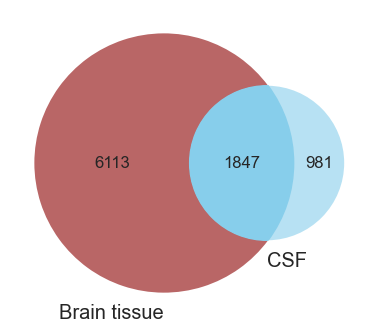

In [128]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# entire dataset
v = venn2([set(Higginbotham2020_brain["Uniprot"]), set(Higginbotham2020_CSF["Uniprot"])], ["Brain tissue", "CSF"], 
    set_colors=("darkred", "skyblue"))
v.get_patch_by_id("11").set_color("skyblue")
v.get_patch_by_id("10").set_alpha(0.6)
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("01").set_alpha(0.6)

plt.show()
fig.savefig(fig_path + "Venn_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight")

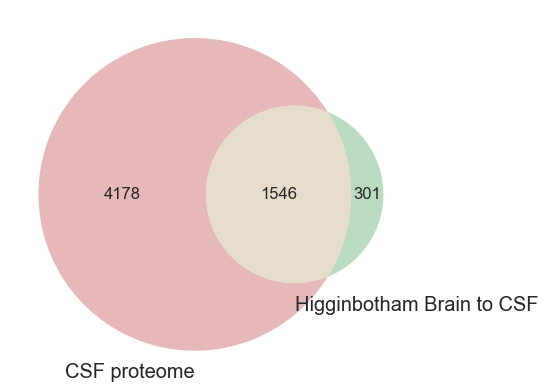

In [129]:
venn2([set(csf["Uniprot"]), set(brain_to_CSF)], ["CSF proteome", "Higginbotham Brain to CSF"])
plt.show()

In [130]:
additional_brain_to_csf_proteins = set(brain_to_CSF) - set(csf["Uniprot"])
len(additional_brain_to_csf_proteins)

301

In [131]:
a = df_pred[df_pred["Uniprot"].isin(additional_brain_to_csf_proteins)]
print(len(a))
print(len(a[a["CSF_proba"] > 0.5])/len(a))
print(len(a[a["CSF_proba_2plus"] > 0.5])/len(a))
print(len(a[a["CSF_proba_3plus"] > 0.5])/len(a))

251
0.6772908366533864
0.5896414342629482
0.549800796812749


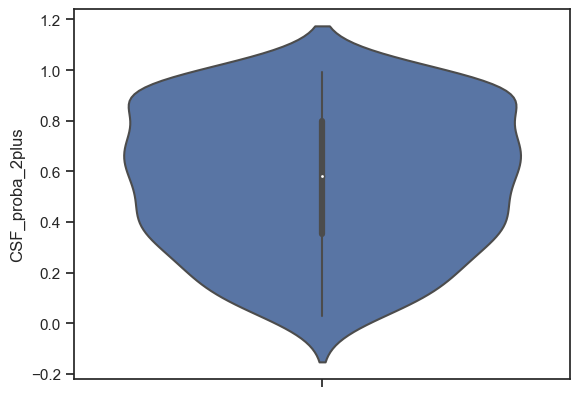

In [132]:
sns.violinplot(y=a["CSF_proba_2plus"])
plt.show()

In [133]:
brain_tissue = set(Higginbotham2020_brain["Uniprot"])
only_brain = set(Higginbotham2020_brain["Uniprot"]) - set(Higginbotham2020_CSF["Uniprot"])
brain_to_CSF = set(Higginbotham2020_brain["Uniprot"]).intersection(set(Higginbotham2020_CSF["Uniprot"]))
print("Proteins found in brain tissue:", len(brain_tissue))
print("Proteins only found in brain tissue:", len(only_brain))
print("Proteins found in brain and CSF tissue:", len(brain_to_CSF))

Proteins found in brain tissue: 7960
Proteins only found in brain tissue: 6113
Proteins found in brain and CSF tissue: 1847


In [134]:
brain_tissue_proba = df_pred[df_pred["Uniprot"].isin(brain_tissue)]
only_brain_proba = df_pred[df_pred["Uniprot"].isin(only_brain)]
brain_to_CSF_proba = df_pred[df_pred["Uniprot"].isin(brain_to_CSF)]
print("Proteins found in brain tissue in our data set:", len(brain_tissue_proba))
print("Proteins only found in brain tissue in our data set:", len(only_brain_proba))
print("Proteins found in brain and CSF tissue in our data set:", len(brain_to_CSF_proba))

Proteins found in brain tissue in our data set: 7605
Proteins only found in brain tissue in our data set: 5824
Proteins found in brain and CSF tissue in our data set: 1781


In [135]:
# how well does the model do on positive proteins that are part of the training set?
x = brain_to_CSF_proba[brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("CSF proteins:", len(x[x["CSF_proba"] > 0.5])/len(x))
x = only_brain_proba[only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("Non-CSF proteins:", len(x[x["CSF_proba"] < 0.5])/len(x))

#### TO DO ####
# these are not the correct datasets (since 2+ and 3+ have been trained on a smaller set than brain elevated)

x = brain_to_CSF_proba[brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("CSF proteins:", len(x[x["CSF_proba_2plus"] > 0.5])/len(x))
x = only_brain_proba[only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("Non-CSF proteins:", len(x[x["CSF_proba_2plus"] < 0.5])/len(x))

# how well does the model do on positive proteins that are part of the training set?
x = brain_to_CSF_proba[brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("CSF proteins:", len(x[x["CSF_proba_3plus"] > 0.5])/len(x))
x = only_brain_proba[only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("Non-CSF proteins:", len(x[x["CSF_proba_3plus"] < 0.5])/len(x))

CSF proteins: 0.7839805825242718
Non-CSF proteins: 0.6633802816901408
CSF proteins: 0.7718446601941747
Non-CSF proteins: 0.6887323943661972
CSF proteins: 0.7524271844660194
Non-CSF proteins: 0.7591549295774648


In [136]:
# how well does the model do on positive proteins that are not part of the training set?
y = brain_to_CSF_proba[-brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("CSF proteins:", len(y[y["CSF_proba"] > 0.5])/len(y))
y = only_brain_proba[-only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("Non-CSF proteins:", len(y[y["CSF_proba"] < 0.5])/len(y))

#### TO DO ####
# these are not the correct datasets (since 2+ and 3+ have been trained on a smaller set than brain elevated)

y = brain_to_CSF_proba[-brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("CSF proteins:", len(y[y["CSF_proba_2plus"] > 0.5])/len(y))
y = only_brain_proba[-only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("Non-CSF proteins:", len(y[y["CSF_proba_2plus"] < 0.5])/len(y))

y = brain_to_CSF_proba[-brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("CSF proteins:", len(y[y["CSF_proba_3plus"] > 0.5])/len(y))
y = only_brain_proba[-only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("Non-CSF proteins:", len(y[y["CSF_proba_3plus"] < 0.5])/len(y))

CSF proteins: 0.7384952520087655
Non-CSF proteins: 0.6587798201016817
CSF proteins: 0.6866325785244705
Non-CSF proteins: 0.7414939382088385
CSF proteins: 0.6683710737764792
Non-CSF proteins: 0.7631990614000782


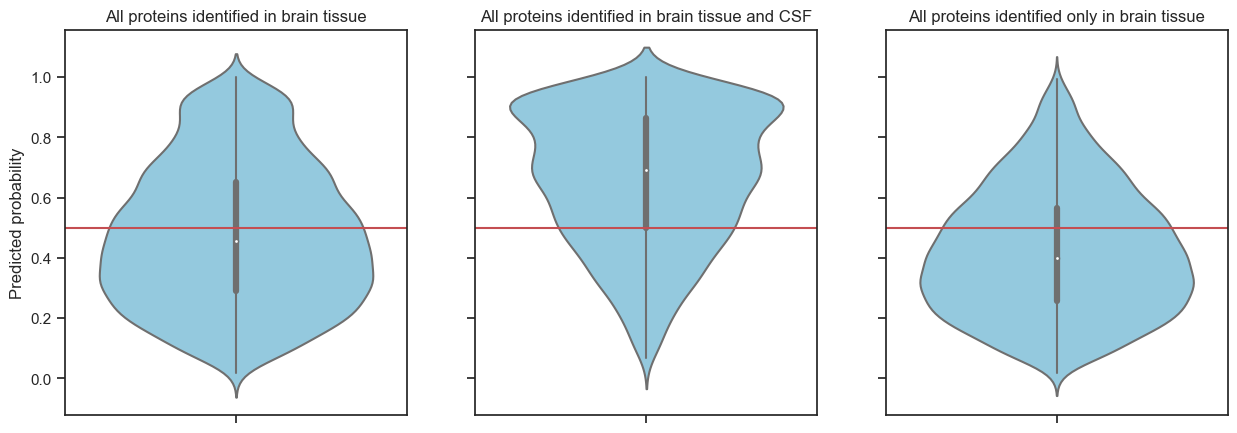

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.violinplot(y="CSF_proba", data=brain_tissue_proba, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba", data=brain_to_CSF_proba, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba", data=only_brain_proba, orient="v", palette=["skyblue"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Violin_probability_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight")

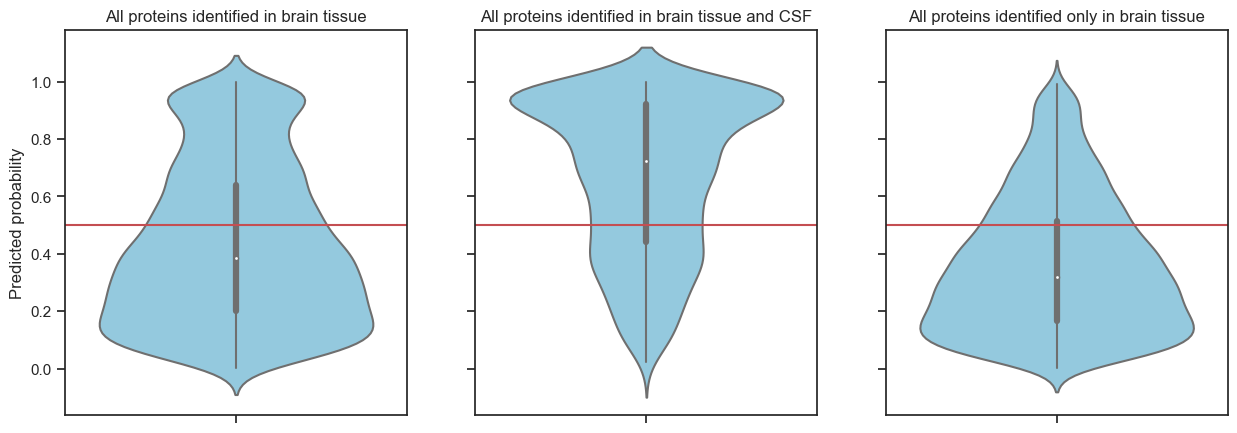

In [138]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.violinplot(y="CSF_proba_2plus", data=brain_tissue_proba, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_2plus", data=brain_to_CSF_proba, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_2plus", data=only_brain_proba, orient="v", palette=["skyblue"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
# fig.savefig(fig_path + "Violin_probability_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight")

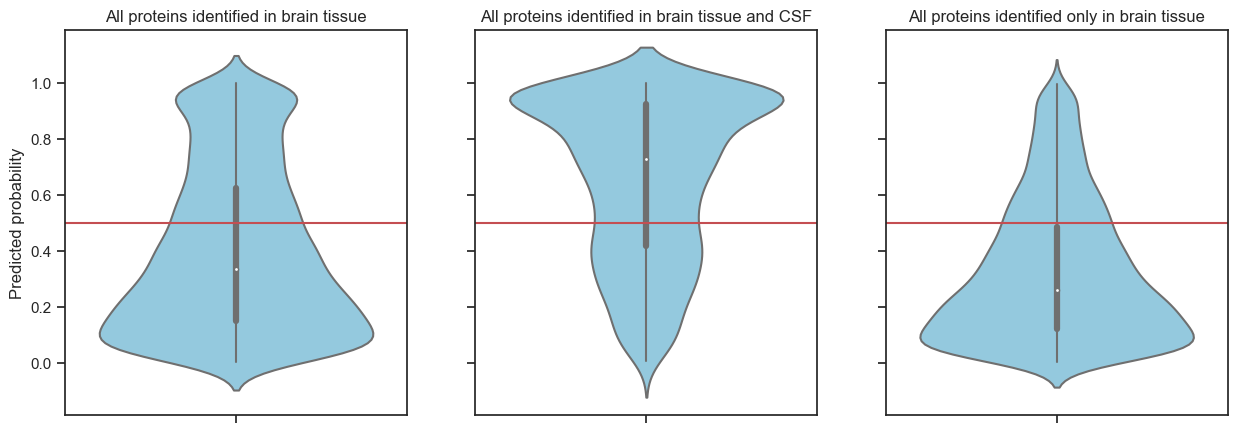

In [139]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.violinplot(y="CSF_proba_3plus", data=brain_tissue_proba, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_3plus", data=brain_to_CSF_proba, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_3plus", data=only_brain_proba, orient="v", palette=["skyblue"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
# fig.savefig(fig_path + "Violin_probability_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight")

In [140]:
print("Entire CSF proteome")
print("Median predicted probability for all brain tissue proteins:", round(np.median(brain_tissue_proba["CSF_proba"]), 4))
print("Median predicted probability for brain tissue to CSF proteins:", round(np.median(brain_to_CSF_proba["CSF_proba"]), 4))
print("Median predicted probability for only brain tissue proteins:", round(np.median(only_brain_proba["CSF_proba"]), 4))

print("2+ studies CSF proteome")
print("Median predicted probability for all brain tissue proteins:", round(np.median(brain_tissue_proba["CSF_proba_2plus"]), 4))
print("Median predicted probability for brain tissue to CSF proteins:", round(np.median(brain_to_CSF_proba["CSF_proba_2plus"]), 4))
print("Median predicted probability for only brain tissue proteins:", round(np.median(only_brain_proba["CSF_proba_2plus"]), 4))

print("3+ studies  CSF proteome")
print("Median predicted probability for all brain tissue proteins:", round(np.median(brain_tissue_proba["CSF_proba_3plus"]), 4))
print("Median predicted probability for brain tissue to CSF proteins:", round(np.median(brain_to_CSF_proba["CSF_proba_3plus"]), 4))
print("Median predicted probability for only brain tissue proteins:", round(np.median(only_brain_proba["CSF_proba_3plus"]), 4))

Entire CSF proteome
Median predicted probability for all brain tissue proteins: 0.4555
Median predicted probability for brain tissue to CSF proteins: 0.69
Median predicted probability for only brain tissue proteins: 0.3998
2+ studies CSF proteome
Median predicted probability for all brain tissue proteins: 0.3839
Median predicted probability for brain tissue to CSF proteins: 0.7247
Median predicted probability for only brain tissue proteins: 0.3175
3+ studies  CSF proteome
Median predicted probability for all brain tissue proteins: 0.3351
Median predicted probability for brain tissue to CSF proteins: 0.7302
Median predicted probability for only brain tissue proteins: 0.2611


Entire CSF proteome
Median predicted probability for all brain tissue proteins: 0.4918
Median predicted probability for brain tissue to CSF proteins: 0.7366
Median predicted probability for only brain tissue proteins: 0.4338
2+ studies CSF proteome
Median predicted probability for all brain tissue proteins: 0.373
Median predicted probability for brain tissue to CSF proteins: 0.7381
Median predicted probability for only brain tissue proteins: 0.305
3+ studies  CSF proteome
Median predicted probability for all brain tissue proteins: 0.3149
Median predicted probability for brain tissue to CSF proteins: 0.734
Median predicted probability for only brain tissue proteins: 0.2373

In [141]:
print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba"] > 0.5).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba"] > 0.5).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba"] > 0.5).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_2plus"] > 0.5).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_2plus"] > 0.5).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_2plus"] > 0.5).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_3plus"] > 0.5).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_3plus"] > 0.5).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_3plus"] > 0.5).sum()/len(only_brain_proba), 4))

Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.4363
	in brain tissue to CSF proteins: 0.749
	in only brain tissue proteins: 0.3407
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.3683
	in brain tissue to CSF proteins: 0.7063
	in only brain tissue proteins: 0.2649
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.3428
	in brain tissue to CSF proteins: 0.6878
	in only brain tissue proteins: 0.2373


In [142]:
print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba"] > 0.8).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba"] > 0.8).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba"] > 0.8).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_2plus"] > 0.8).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_2plus"] > 0.8).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_2plus"] > 0.8).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_3plus"] > 0.8).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_3plus"] > 0.8).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_3plus"] > 0.8).sum()/len(only_brain_proba), 4))

Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.1143
	in brain tissue to CSF proteins: 0.3358
	in only brain tissue proteins: 0.0465
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.1411
	in brain tissue to CSF proteins: 0.4177
	in only brain tissue proteins: 0.0565
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.1478
	in brain tissue to CSF proteins: 0.4183
	in only brain tissue proteins: 0.0651


In [143]:
# is brain expression lower in false positives compared to true positives?
FP_hi = only_brain_proba[only_brain_proba["CSF_proba"] > 0.5]
print("Number of false positives:", len(FP_hi))
TP_hi = brain_to_CSF_proba[brain_to_CSF_proba["CSF_proba"] > 0.5]
print("Number of true positives:", len(TP_hi))
FN_hi = brain_to_CSF_proba[brain_to_CSF_proba["CSF_proba"] < 0.5]
print("Number of false negatives:", len(FN_hi))
TN_hi = only_brain_proba[only_brain_proba["CSF_proba"] < 0.5]
print("Number of true negatives:", len(TN_hi))

Number of false positives: 1984
Number of true positives: 1334
Number of false negatives: 447
Number of true negatives: 3840


In [144]:
A = set(brain_to_CSF_proba["Uniprot"]).intersection(set(brain_tissue_proba[brain_tissue_proba["CSF_proba"] > 0.5]["Uniprot"]))
B = set(brain_to_CSF_proba["Uniprot"]).intersection(set(brain_tissue_proba[brain_tissue_proba["CSF_proba"] < 0.5]["Uniprot"]))

print("Fraction of protein secreted to CSF...")
print("\tin proteins predicted to be in CSF:", 
    round(len(A)/len(brain_tissue_proba[brain_tissue_proba["CSF_proba"] > 0.5]), 4)) # 1271/(1271+1881)
print("\tin proteins predicted not to be in CSF:", 
    round(len(B)/len(brain_tissue_proba[brain_tissue_proba["CSF_proba"] < 0.5]), 4)) # 316/(316+3045)

Fraction of protein secreted to CSF...
	in proteins predicted to be in CSF: 0.402
	in proteins predicted not to be in CSF: 0.1043


In [145]:
_, p = mannwhitneyu(brain_tissue_proba["CSF_proba"], brain_to_CSF_proba["CSF_proba"])
print("p-value:", p)

p-value: 3.589612339554739e-178


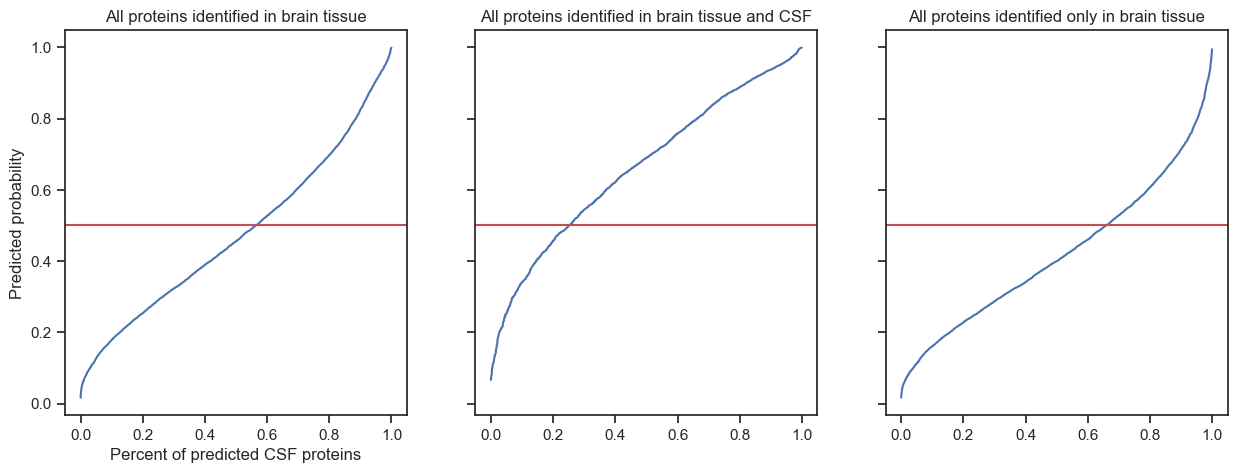

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)

ax[0].plot([len(brain_tissue_proba[brain_tissue_proba["CSF_proba"] < i])/len(brain_tissue_proba) for i in 
    brain_tissue_proba["CSF_proba"]], brain_tissue_proba["CSF_proba"])
ax[0].set(xlabel="Percent of predicted CSF proteins", ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
ax[1].plot([len(brain_to_CSF_proba[brain_to_CSF_proba["CSF_proba"] < i])/len(brain_to_CSF_proba) for i in 
    brain_to_CSF_proba["CSF_proba"]], brain_to_CSF_proba["CSF_proba"])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
ax[2].plot([len(only_brain_proba[only_brain_proba["CSF_proba"] < i])/len(only_brain_proba) for i in 
    only_brain_proba["CSF_proba"]], only_brain_proba["CSF_proba"])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Probability_fraction_predicted_CSF_Higginbotham.png", bbox_inches="tight")

In [149]:
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]
brain_exp["log2(Brain expression)"] = np.log2(brain_exp["Brain expression"])
brain_exp_CSF = brain_exp.merge(df_pred[["Uniprot", "CSF", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_CSF["CSF_proba_binary"] = np.where(brain_exp_CSF["CSF_proba"] > 0.5, 1, -1)

In [150]:
# overlap with expression data
brain_exp_FP_hi = brain_exp.merge(FP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_FP_hi["CSF_proba_binary"] = np.where(brain_exp_FP_hi["CSF_proba"] > 0.5, 1, -1)
brain_exp_TP_hi = brain_exp.merge(TP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_TP_hi["CSF_proba_binary"] = np.where(brain_exp_TP_hi["CSF_proba"] > 0.5, 1, -1)

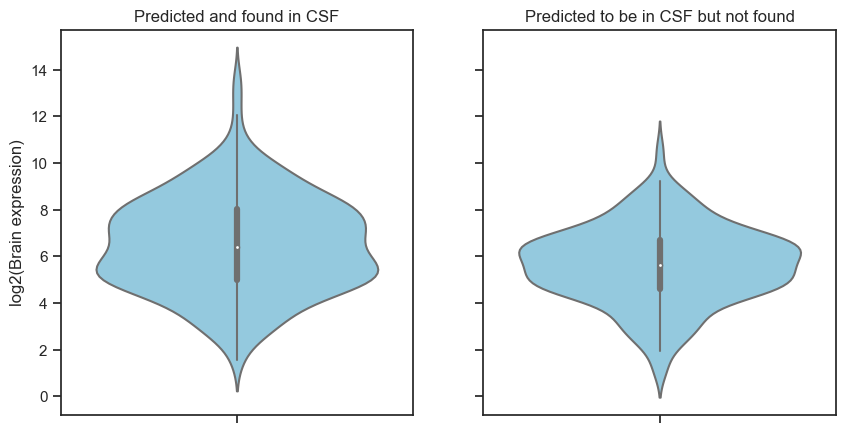

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.violinplot(y="log2(Brain expression)", data=brain_exp_TP_hi, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, title="Predicted and found in CSF")
sns.violinplot(y="log2(Brain expression)", data=brain_exp_FP_hi, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="Predicted to be in CSF but not found")

plt.show()
fig.savefig(fig_path + "Violin_true_and_false_positives_brain_expression_Higginbotham.png", bbox_inches="tight")